---
<div style="text-align: right"> Dazed & Confusion Matrix 2.0 <br> REQUIRED TO HAVE TENSORFLOW & TENSORFLOW-PROBABILITY INSTALLED </div>

--- 

# Load libriaries and functions.

In [1]:
# theano
import theano
print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow as tf
print('tensorflow: %s' % tf.__version__)
# keras
from tensorflow import keras
print('keras: %s' % keras.__version__)
import tensorflow_probability as tfp
print('tf_probability: %s' % tfp.__version__)
import autokeras as ak
print('autokeras: %s' % ak.__version__)

theano: 1.0.4
tensorflow: 2.3.0
keras: 2.4.0
tf_probability: 0.11.0
autokeras: 1.0.12


In [2]:
import pandas as pd
import numpy as np
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [3]:
import requests
import io

In [4]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Define helper functions

In [5]:
# Define helper functions.
scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000, behaviour="deprecated", contamination="auto", random_state=0)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

# Loading the Data

As sensors tend to drift due to aging, theretically, it is better to only use data from the past month six.

In [6]:
# Downloading the csv file from your GitHub account

url = "https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/Dazed-Confusion-Matrix/dev/data/TRAIN_911_DEMO_MERGED_ENCODED.CSV" # Make sure the url is the raw version of the file on GitHub
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

train_data = pd.read_csv(io.StringIO(download.decode('utf-8')))

# Downloading the csv file from your GitHub account

url_1 = "https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/Dazed-Confusion-Matrix/dev/data/TEST_911_DEMO_MERGED_ENCODED.CSV" # Make sure the url is the raw version of the file on GitHub
download_1 = requests.get(url_1).content

# Reading the downloaded content and turning it into a pandas dataframe

test_data = pd.read_csv(io.StringIO(download_1.decode('utf-8')))


In [7]:
test_data['Priority_OUT_OF_SERVICE'] = test_data['Priority_OUT OF SERVICE']
test_data = test_data.drop(['Priority_OUT OF SERVICE'], axis=1)
train_data['Priority_OUT_OF_SERVICE'] = train_data['Priority_OUT OF SERVICE']
train_data = train_data.drop(['Priority_OUT OF SERVICE'], axis=1)

In [8]:
test_data.isnull().sum()

Description                 0
Post                        0
District                    0
Neighborhood                0
Longitude                   0
Latitude                    0
Premise                     0
CallDescription             0
Year                        0
median_household_income     0
households_below_poverty    0
perc18_24                   0
perc25_64                   0
perc65up                    0
perc_asian                  0
perc_aa                     0
perc_hisp                   0
perc_white                  0
median_price_homes_sold     0
racial_diversity_index      0
num_households              0
Month                       0
crime_hour                  0
Outside                     0
Weapon_FIREARM              0
Weapon_HANDS                0
Weapon_KNIFE                0
Weapon_NONE                 0
Weapon_OTHER                0
call_hour                   0
Season_autumn               0
Season_spring               0
Season_summer               0
Season_win

In [9]:
train_data.Description.unique()

array([ 8,  7,  3,  0,  5, 11,  4, 12,  1, 13,  2, 14,  9, 10,  6],
      dtype=int64)

In [10]:
train_data['Description'].value_counts()

7     1746
8     1382
5     1017
3      996
4      805
0      517
12     461
2       97
14      89
10      57
11      50
6       41
13      34
1       31
9       26
Name: Description, dtype: int64

In [11]:
#test_data['Description']=test_data["Description"].astype(np.float64)
#train_data['Description']=train_data["Description"].astype(np.float64)

In [12]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1838 entries, 0 to 1837
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Description               1838 non-null   int64  
 1   Post                      1838 non-null   float64
 2   District                  1838 non-null   int64  
 3   Neighborhood              1838 non-null   int64  
 4   Longitude                 1838 non-null   float64
 5   Latitude                  1838 non-null   float64
 6   Premise                   1838 non-null   int64  
 7   CallDescription           1838 non-null   int64  
 8   Year                      1838 non-null   int64  
 9   median_household_income   1838 non-null   float64
 10  households_below_poverty  1838 non-null   float64
 11  perc18_24                 1838 non-null   float64
 12  perc25_64                 1838 non-null   float64
 13  perc65up                  1838 non-null   float64
 14  perc_asi

In [13]:
X_test = test_data.drop(['Description'], axis=1)
y_test = test_data["Description"]

In [14]:
X_train_full = train_data.drop(['Description'], axis=1)
y_train_full = train_data['Description']

In [15]:
print(X_train_full.shape, X_test.shape, y_train_full.shape, y_test.shape, test_data.shape, train_data.shape)

(7349, 41) (1838, 41) (7349,) (1838,) (1838, 42) (7349, 42)


In [16]:
scaler = StandardScaler()

In [17]:
# Fit only to the training data
scaler.fit(X_train_full)

StandardScaler()

In [18]:
X_train_full = scaler.transform(X_train_full)
X_test = scaler.transform(X_test)

In [19]:
#The validation set contains 1935 units of information from the 7350, which is 26.33% of the data 
X_valid, X_train = X_train_full[:1934], X_train_full[1934:]
y_valid, y_train = y_train_full[:1934], y_train_full[1934:]

In [20]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
ANN_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[41]),  
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(15, activation="softmax")
])

In [22]:
ANN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 41)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                1260      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                315       
Total params: 2,195
Trainable params: 2,195
Non-trainable params: 0
_________________________________________________________________


In [23]:
ANN_model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [24]:
#Set the epich to 150 because when testing different epochs this was the point before validation loss became eratic
ANN_history = ANN_model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))


Epoch 1/50
170/170 [==============================] - 0s 2ms/step - loss: 2.4236 - accuracy: 0.2161 - val_loss: 2.1177 - val_accuracy: 0.3154
Epoch 2/50
170/170 [==============================] - 0s 742us/step - loss: 1.8957 - accuracy: 0.3662 - val_loss: 1.7267 - val_accuracy: 0.4012
Epoch 3/50
170/170 [==============================] - 0s 807us/step - loss: 1.5738 - accuracy: 0.4720 - val_loss: 1.4653 - val_accuracy: 0.5109
Epoch 4/50
170/170 [==============================] - 0s 759us/step - loss: 1.3631 - accuracy: 0.5638 - val_loss: 1.2984 - val_accuracy: 0.5812
Epoch 5/50
170/170 [==============================] - 0s 900us/step - loss: 1.2253 - accuracy: 0.6260 - val_loss: 1.1821 - val_accuracy: 0.6339
Epoch 6/50
170/170 [==============================] - 0s 787us/step - loss: 1.1284 - accuracy: 0.6567 - val_loss: 1.1026 - val_accuracy: 0.6618
Epoch 7/50
170/170 [==============================] - 0s 813us/step - loss: 1.0609 - accuracy: 0.6770 - val_loss: 1.0501 - val_accuracy: 0

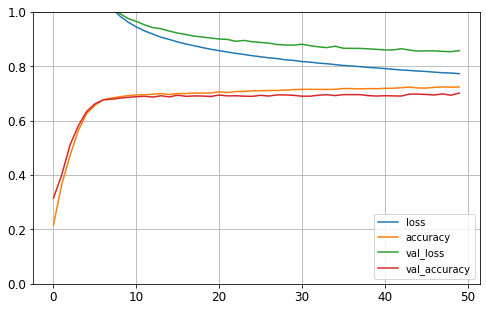

In [25]:
pd.DataFrame(ANN_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [26]:
ANN_model.evaluate(X_test, y_test)

58/58 [==============================] - 0s 606us/step - loss: 0.8419 - accuracy: 0.7100


[0.8419079299979682, 0.7100108813928183]

In [27]:
X_new = X_test[:10]
y_proba = ANN_model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.03, 0.05, 0.88, 0.  , 0.  , 0.02, 0.  , 0.  , 0.  ,
        0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.08, 0.  , 0.  , 0.83, 0.08, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.01, 0.01, 0.2 , 0.  , 0.  , 0.59, 0.16, 0.  , 0.  ,
        0.01, 0.  , 0.  , 0.  ],
       [0.06, 0.  , 0.  , 0.  , 0.  , 0.93, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.94, 0.02, 0.  , 0.  , 0.01, 0.02, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.11, 0.  , 0.  , 0.82, 0.05, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.02, 0.06, 0.12, 0.64, 0.  , 0.  , 0.1 , 0.02, 0.  , 0.  ,
        0.03, 0.01, 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.04, 0.01, 0.  , 0.  , 0.3 , 0.65, 0.  , 0.  ,
        0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.02, 0.02, 0.13, 0.  , 0.  , 0.77, 0.05, 0.  , 0.  ,
        0.01, 0.  , 0.  , 0.  ],
       [0.04, 0.  , 0.01, 0.01, 0.  ,

In [28]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(ANN_model.predict(X_new), axis=-1)
y_pred

array([4, 7, 7, 5, 3, 7, 4, 8, 7, 5], dtype=int64)

In [29]:
y_new = y_test[:10]
y_new

0    4
1    7
2    7
3    5
4    3
5    7
6    4
7    7
8    7
9    5
Name: Description, dtype: int64

# Trying it under autokeras

In [30]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
# It tries 10 different models.
clf = ak.StructuredDataClassifier(overwrite=True, max_trials=5)
# Feed the structured data classifier with training data.
clf.fit(X_train, y_train, epochs=10)

Trial 5 Complete [00h 00m 09s]
val_accuracy: 0.07902163687676388

Best val_accuracy So Far: 0.07902163687676388
Total elapsed time: 00h 00m 51s
INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass

In [32]:
model = clf.export_model()
model.summary()


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 41)                0         
_________________________________________________________________
normalization (Normalization (None, 41)                83        
________________________

In [22]:
Auto_model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[41]),
    keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=41, output_mode="count"),
    keras.layers.experimental.preprocessing.Normalization(),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(15, activation="softmax")
])

In [23]:
Auto_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
category_encoding (CategoryE (None, 41)                0         
_________________________________________________________________
normalization (Normalization (None, 41)                83        
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1344      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 15)                495       
Total params: 2,978
Trainable params: 2,895
Non-trainable params: 83
_________________________________________________________________


In [24]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [25]:
Auto_model.compile(loss="sparse_categorical_crossentropy",
              optimizer= opt,
              metrics=["accuracy"])

In [ ]:
#Set the epich to 150 because when testing different epochs this was the point before validation loss became eratic
Auto_history = Auto_model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))
exit()

Epoch 1/50


In [ ]:
pd.DataFrame(Auto_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
Auto_model.evaluate(X_test, y_test)

In [ ]:
X_new = X_test[:10]
y_proba = Auto_model.predict(X_new)

In [ ]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(Auto_model.predict(X_new), axis=-1)
y_pred

In [ ]:
y_new = y_test[:10]
y_new

# Trying the original ANN with adam as the optimizer

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
adam_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[41]),  
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(15, activation="softmax")
])

In [ ]:
adam_model.summary()

In [ ]:
adam_model.compile(loss="sparse_categorical_crossentropy",
              optimizer= "adam",
              metrics=["accuracy"])

In [ ]:
#Set the epich to 150 because when testing different epochs this was the point before validation loss became eratic
adam_history = adam_model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))

In [ ]:
pd.DataFrame(adam_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
adam_model.evaluate(X_test, y_test)

In [ ]:
X_new = X_test[:10]
y_proba = adam_model.predict(X_new)

In [ ]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(adam_model.predict(X_new), axis=-1)
y_pred

In [ ]:
y_new = y_test[:10]
y_new

# Trying to improve for accuracy with custom activation fucntion

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## Custom Activation Function
--- 

In [ ]:
from keras import backend as K

def my_swish(z, beta=1.0):
    return z * tf.math.sigmoid(beta * z)

In [ ]:
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'my_swish': Activation(my_swish)})

In [ ]:
swish_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[41]),  
    keras.layers.Dense(30, activation="my_swish"),
    keras.layers.Dense(20, activation="my_swish"),
    keras.layers.Dense(15, activation="softmax")
])

In [ ]:
swish_model.summary()

In [ ]:
swish_model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
#Set the epich to 150 because when testing different epochs this was the point before validation loss became eratic
swish_history = swish_model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))

In [ ]:
pd.DataFrame(swish_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
swish_model.evaluate(X_test, y_test)

In [ ]:
X_new = X_test[:10]
y_proba = swish_model.predict(X_new)

In [ ]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(swish_model.predict(X_new), axis=-1)
y_pred

In [ ]:
y_new = y_test[:10]
y_new